# Libraries import

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.core.common import SettingWithCopyWarning
from pandas.tseries.offsets import DateOffset
import warnings

# Ignore the "SettingWithCopyWarning"
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# Data pre-processing

In [2]:
datasets_path = r"C:\Users\shres\OneDrive\Desktop\EXL-Hackathon\data_sets"
unemp_rt_file = datasets_path + r"\\" + r"unemployment_rate.csv"
df_unemp_rt = pd.read_csv(unemp_rt_file)
df = df_unemp_rt.iloc[267:,:]
df.rename(columns={'Title':'MONTH',
                   'Unemployment rate (aged 16 and over, seasonally adjusted): %':'UNEMP_RT'},inplace=True)
df['UNEMP_RT'] = df['UNEMP_RT'].astype(float)
df.reset_index(inplace=True,drop=True)
df.loc[:, 'month_abbr'] = df['MONTH'].str.split().str[-1].copy()
df.loc[:, 'year'] = df['MONTH'].str.split().str[0].copy()
df.loc[:,'#month'] = df['month_abbr'].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
df['#month'] = df['#month'].astype(str)
df['#month'] = df['#month'].apply(lambda x: str(x).zfill(2))
from datetime import datetime
df['DATE'] = '01' + '-' + df['#month'] + '-' + df['year']
df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date())
df.drop(columns=['MONTH','month_abbr','year','#month'],inplace=True)
df = df.set_index('DATE')
# df.reset_index(inplace=True)

# Visualization

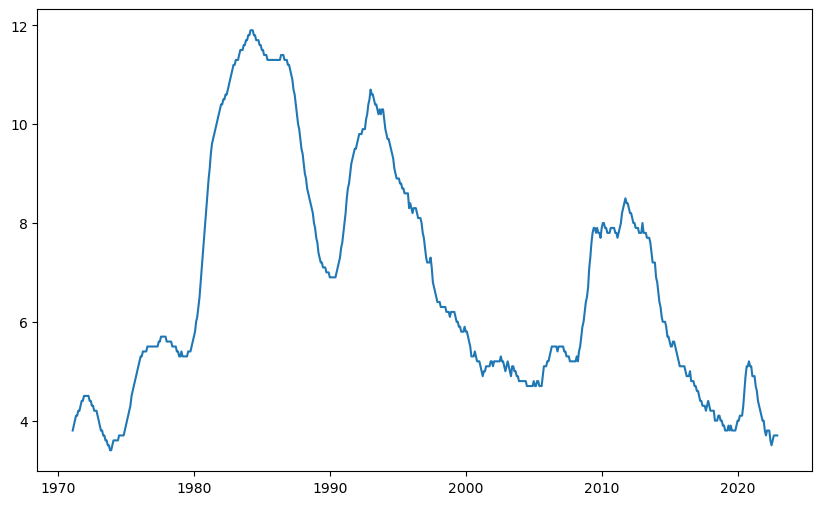

In [3]:
plt.rcParams.update({'figure.figsize':(10,6)})
plt.plot(df['UNEMP_RT'])

# Time series decomposition

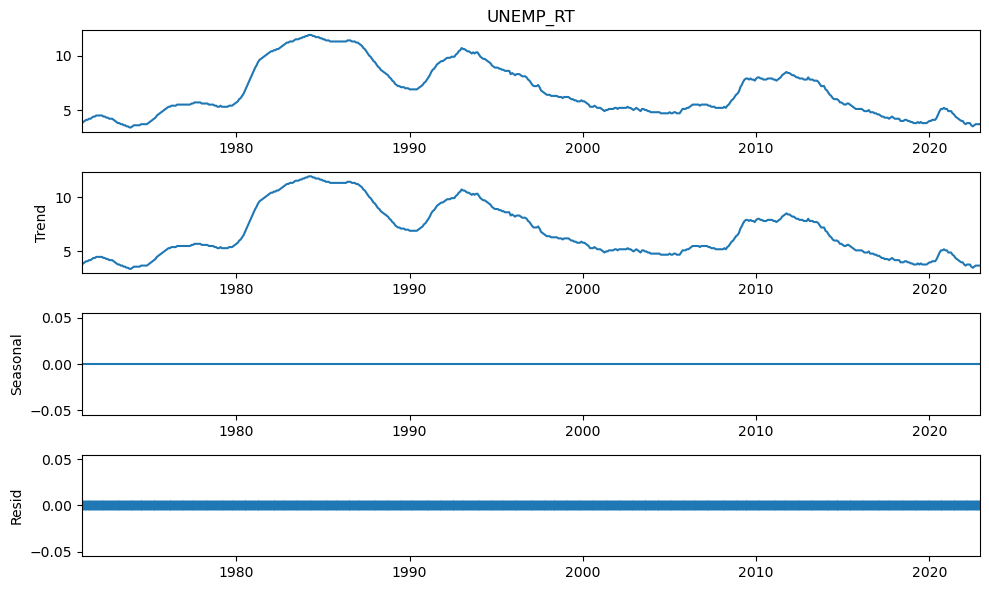

In [4]:
add_dec = seasonal_decompose(df['UNEMP_RT'],model='additive',period=1)
add_dec.plot()
plt.show()

In [5]:
df_dec = pd.concat([add_dec.seasonal, add_dec.trend, add_dec.resid, add_dec.observed],axis=1)
df_dec.columns = ['seasonality','trend','residual','obs_value']

In [6]:
df_dec.head()

,seasonality,trend,residual,obs_value
DATE,,,,
1971-02-01,0.0,3.8,0.0,3.8
1971-03-01,0.0,3.9,0.0,3.9
1971-04-01,0.0,4.0,0.0,4.0
1971-05-01,0.0,4.1,0.0,4.1
1971-06-01,0.0,4.1,0.0,4.1


# Stationarity check

In [7]:
adfuller_result = adfuller(df['UNEMP_RT'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('Non-stationary time series, convert to stationary time series')
else:
    print('Stationary time series, ARIMA can be implemented')

ADF statistics:  -2.3544807436910333
p-value:  0.1549980060325768
Non-stationary time series, convert to stationary time series


In [8]:
df['first_difference'] = df['UNEMP_RT'] - df['UNEMP_RT'].shift()
df_diff = df.dropna()

In [9]:
adfuller_result = adfuller(df_diff['first_difference'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('Non-stationary time series, convert to stationary time series')
else:
    print('Stationary time series, ARIMA can be implemented')

ADF statistics:  -4.805010233865878
p-value:  5.3198323508798304e-05
Stationary time series, ARIMA can be implemented


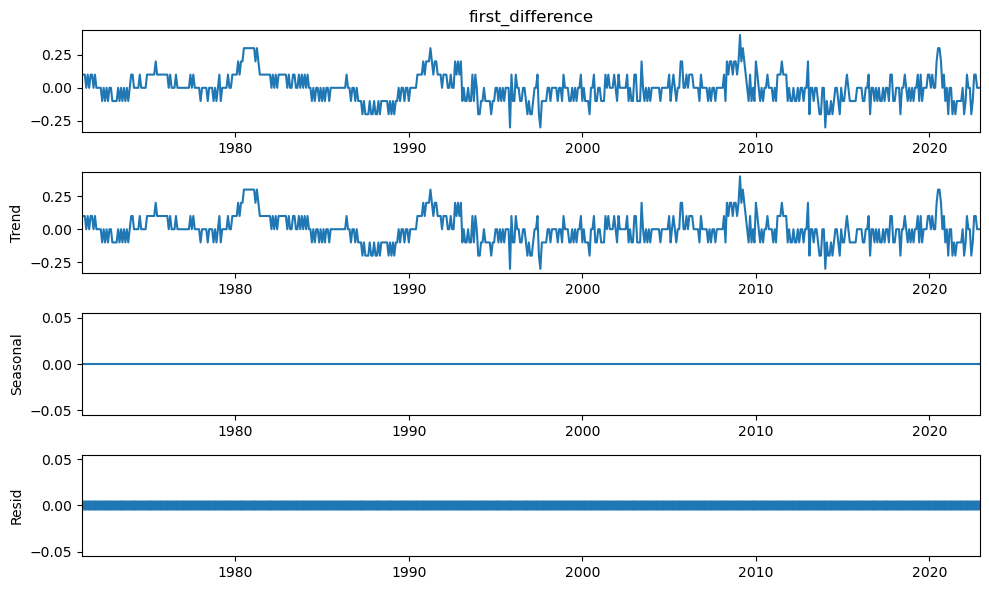

In [10]:
add_dec = seasonal_decompose(df_diff['first_difference'],model='additive',period=1)
add_dec.plot()
plt.show()

# ACF and PACF plots

C:\Users\shres\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


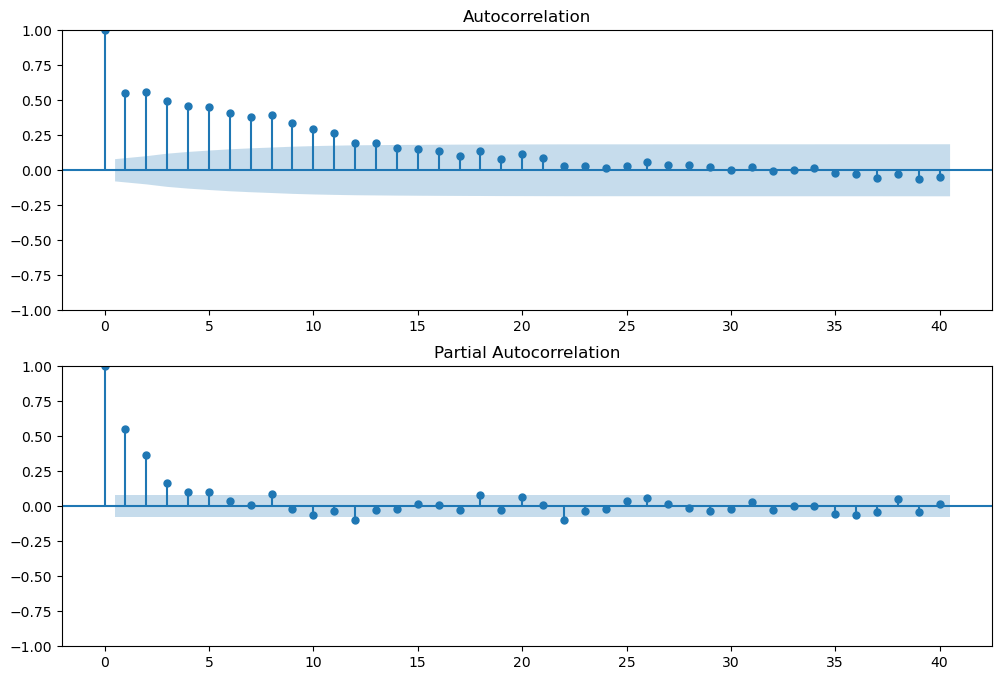

In [11]:
# import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff['first_difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff['first_difference'].iloc[13:],lags=40,ax=ax2)

# Finding best orders

In [12]:
stepwise_fit = auto_arima(df['UNEMP_RT'], start_p=5,max_p=10, d=1,start_q =13,max_q=20,trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(5,1,13)(0,0,0)[0] intercept   : AIC=-1352.017, Time=9.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1019.114, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1241.703, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1141.240, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1021.113, Time=0.13 sec
 ARIMA(4,1,13)(0,0,0)[0] intercept   : AIC=-1345.465, Time=8.43 sec
 ARIMA(5,1,12)(0,0,0)[0] intercept   : AIC=-1353.822, Time=8.59 sec
 ARIMA(4,1,12)(0,0,0)[0] intercept   : AIC=-1347.423, Time=8.42 sec
 ARIMA(5,1,11)(0,0,0)[0] intercept   : AIC=-1353.768, Time=7.43 sec
 ARIMA(6,1,12)(0,0,0)[0] intercept   : AIC=-1353.510, Time=8.45 sec
 ARIMA(4,1,11)(0,0,0)[0] intercept   : AIC=-1346.832, Time=7.07 sec
 ARIMA(6,1,11)(0,0,0)[0] intercept   : AIC=-1352.886, Time=7.84 sec
 ARIMA(6,1,13)(0,0,0)[0] intercept   : AIC=-1350.137, Time=9.65 sec
 ARIMA(5,1,12)(0,0,0)[0]             : AIC=-1356.344, Time=5.92 sec
 ARIMA(4,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  623
Model:              SARIMAX(5, 1, 11)   Log Likelihood                 695.658
Date:                Mon, 24 Apr 2023   AIC                          -1357.317
Time:                        13:19:18   BIC                          -1281.957
Sample:                             0   HQIC                         -1328.028
                                - 623                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1773      0.152      1.163      0.245      -0.122       0.476
ar.L2          0.2790      0.146      1.914      0.056      -0.007       0.565
ar.L3         -0.2890      0.138     -2.098      0.036      -0.559      -0.019
ar.L4         -0.1992      0.113     -1.763      0.078      -0.421       0.022
ar.L5          0.5959      0.092      6.445      0.000       0.415       0.777
ma.L1          0.0875      0.154      0.567      0.571      -0.215       0.390
ma.L2         -0.0022      0.158     -0.014      0.989      -0.312       0.308
ma.L3          0.4132      0.128      3.232      0.001       0.163       0.664
ma.L4          0.4012      0.088      4.548      0.000       0.228       0.574
ma.L5         -0.2985      0.092     -3.252      0.001      -0.478      -0.119
ma.L6          0.0924      0.061      1.506      0.132      -0.028       0.213
ma.L7          0.0025      0.057      0.044      0.965      -0.110       0.115
ma.L8          0.2012      0.050      3.987      0.000       0.102       0.300
ma.L9          0.1316      0.060      2.189      0.029       0.014       0.249
ma.L10         0.0098      0.073      0.133      0.894      -0.134       0.154
ma.L11         0.0833      0.066      1.267      0.205      -0.045       0.212
sigma2         0.0062      0.000     18.902      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 9.02
Prob(Q):                              0.85   Prob(JB):                         0.01
Heteroskedasticity (H):               2.53   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Train-test split

In [13]:
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]
print(len(df_train))
print(len(df_test))

611
12


# Model training (df_train)

In [14]:
model = ARIMA(df_train['UNEMP_RT'],order=(5,1,11))
model = model.fit()
model.summary()

C:\Users\shres\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shres\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shres\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shres\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               UNEMP_RT   No. Observations:                  611
Model:                ARIMA(5, 1, 11)   Log Likelihood                 687.654
Date:                Mon, 24 Apr 2023   AIC                          -1341.307
Time:                        13:19:23   BIC                          -1266.278
Sample:                    02-01-1971   HQIC                         -1312.121
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1662      0.173      0.963      0.335      -0.172       0.504
ar.L2          0.2161      0.146      1.482      0.138      -0.070       0.502
ar.L3         -0.1221      0.124     -0.987      0.324      -0.365       0.120
ar.L4         -0.3142      0.127     -2.476      0.013      -0.563      -0.065
ar.L5          0.6204      0.105      5.889      0.000       0.414       0.827
ma.L1          0.0850      0.176      0.482      0.630      -0.261       0.431
ma.L2          0.0834      0.162      0.514      0.607      -0.235       0.402
ma.L3          0.2872      0.122      2.345      0.019       0.047       0.527
ma.L4          0.4824      0.089      5.423      0.000       0.308       0.657
ma.L5         -0.3515      0.099     -3.545      0.000      -0.546      -0.157
ma.L6          0.1111      0.061      1.822      0.069      -0.008       0.231
ma.L7          0.0117      0.060      0.196      0.845      -0.105       0.128
ma.L8          0.1759      0.049      3.572      0.000       0.079       0.272
ma.L9          0.1112      0.066      1.677      0.094      -0.019       0.241
ma.L10         0.0657      0.072      0.917      0.359      -0.075       0.206
ma.L11         0.0651      0.064      1.012      0.312      -0.061       0.191
sigma2         0.0061      0.000     19.394      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.86
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
start = len(df_train)
end = len(df_train) + len(df_test) - 1
pred = model.predict(start=start, end=end, typ='levels')
pred.index=df.index[start:end+1]

<AxesSubplot:xlabel='DATE'>

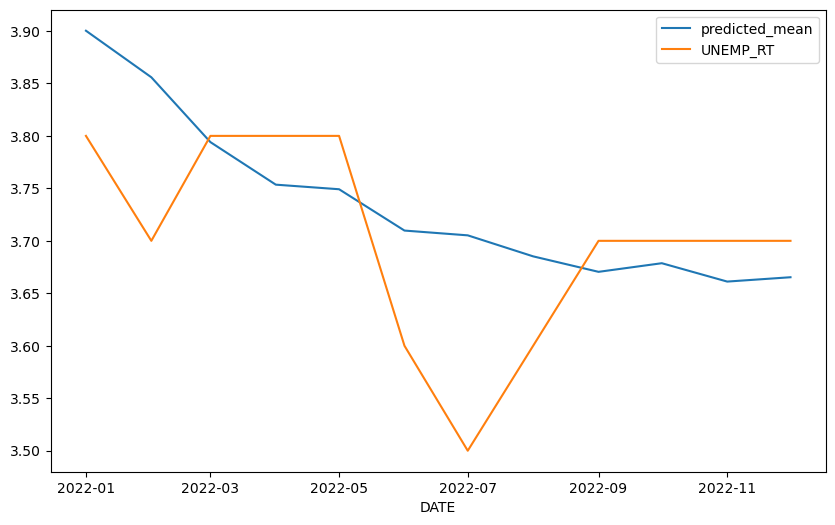

In [16]:
pred.plot(legend=True)
df_test['UNEMP_RT'].plot(legend=True)

In [17]:
df_test.mean()

UNEMP_RT            3.700
first_difference   -0.025
dtype: float64

In [18]:
rmse = sqrt(mean_squared_error(pred,df_test['UNEMP_RT']))
print(rmse)

0.09335050981002431


# Training on full data

In [19]:
model_full = ARIMA(df['UNEMP_RT'],order=(5,1,11))
model_full = model_full.fit()

C:\Users\shres\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shres\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shres\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shres\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
index_future_dates = ['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01']
date_values = [datetime.strptime(date_string, '%Y-%m-%d').date() for date_string in index_future_dates]
pred = model_full.predict(start=len(df), end=len(df)+4, typ='levels').rename('ARIMA preds')
pred.index=date_values

In [21]:
pred

2023-01-01    3.714592
2023-02-01    3.710152
2023-03-01    3.671350
2023-04-01    3.675958
2023-05-01    3.702466
Name: ARIMA preds, dtype: float64

<AxesSubplot:>

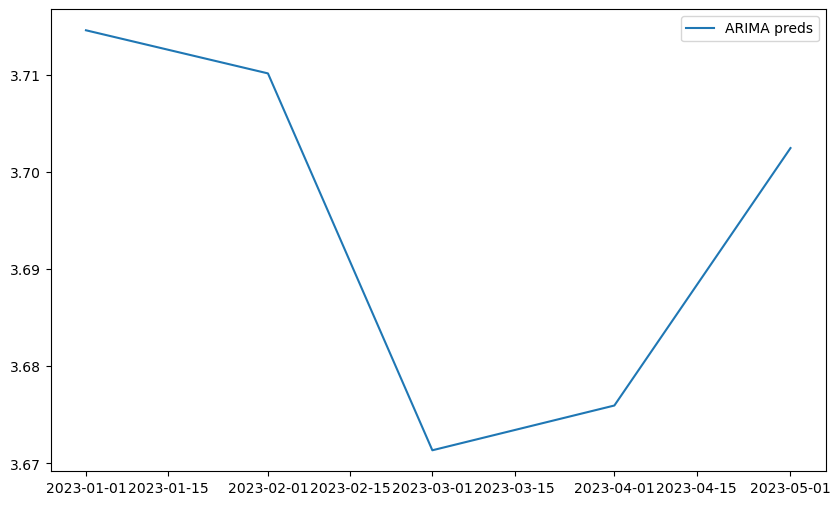

In [22]:
pred.plot(legend=True)

<AxesSubplot:xlabel='DATE'>

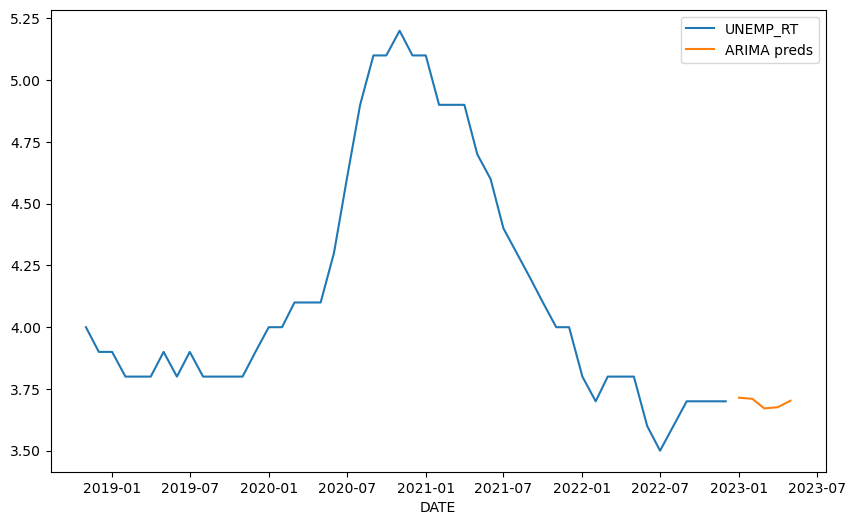

In [23]:
df['UNEMP_RT'].iloc[-50:].plot(legend=True)
pred.plot(legend=True)

In [26]:
df.tail()

,UNEMP_RT,first_difference
DATE,,
2022-08-01,3.6,0.1
2022-09-01,3.7,0.1
2022-10-01,3.7,0.0
2022-11-01,3.7,0.0
2022-12-01,3.7,0.0
